<a href="https://colab.research.google.com/github/cerr/CERR/blob/octave_dev/Jupyter_Notebooks/demo_convolutional_texture_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
In this notebook we demonstrate how to apply Law's filter to a sample image using CERR.

* [CERR](https://github.com/cerr/CERR) provides open-source implementations of several convolutional texture filters, viz., Mean, Laplacian of Gaussian (LoG), Sobel, Laws, Gabor, and Wavelets.

* Filter definitions are compatible with IBSI [guidelines](https://www.overleaf.com/project/5da9e0b82f399f0001ad3970).

## Requirements

* GNU Octave
* CERR
* Python packages for visualization

Note: Installing these tools may incur a one-time extra runtime overhead.

## I/O

In this example, we use sample images in CERR's native `planC` format (imported from DICOM) to compute Law's texture maps, output to Octave matrix and numpy formats.
 
 ## Results
 This notebook comes with a static visualization of a sample filter output.  A second interactive display section is additionally made available on running the notebook.
 

### Download latest Octave compile

In [1]:
%%capture
! apt-get update
! apt-get install gcc g++ gfortran make libblas-dev liblapack-dev libpcre3-dev \
libarpack2-dev libcurl4-gnutls-dev epstool libfftw3-dev transfig libfltk1.3-dev \
libfontconfig1-dev libfreetype6-dev libgl2ps-dev libglpk-dev libreadline-dev \
gnuplot-x11 libgraphicsmagick++1-dev libhdf5-serial-dev openjdk-8-jdk \
libsndfile1-dev llvm-dev lpr texinfo libgl1-mesa-dev libosmesa6-dev pstoedit \
portaudio19-dev libqhull-dev libqrupdate-dev libqscintilla2-dev \
libsuitesparse-dev texlive texlive-generic-recommended libxft-dev zlib1g-dev \
autoconf automake bison flex gperf gzip icoutils librsvg2-bin libtool perl \
rsync tar qtbase5-dev qttools5-dev qttools5-dev-tools libqscintilla2-qt5-dev \
wget git libsundials-dev gnuplot x11-apps

In [2]:
import os, urllib.request, json

In [3]:
# Download latest compiled octave package 
def get_octave(root_path):
  os.chdir(root_path)
  with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
      data = json.loads(url.read().decode())
  fname = data['assets'][0]['name']
  requrl = data['assets'][0]['browser_download_url']
  urllib.request.urlretrieve(requrl, fname)
  # Unzip, identify octave folder name
  !tar xf {fname}
  top_folder = !tar tf {fname} | head -1
  octave_folder = top_folder[0][:-1]
  octave_path = os.path.join(root_path,octave_folder)
  return octave_path

# Set path to Octave exectuable
octave_path = get_octave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

### Install Octave-Python bridge

In [4]:
%%capture
! pip3 install octave_kernel
! pip3 install oct2py==5.3.0

%load_ext oct2py.ipython
from oct2py import octave

### Download CERRx

In [5]:
%%capture
!git clone --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git
import os
currDir = os.getcwd()
os.chdir("/content/CERR")
!git checkout 2847d7df4a889c2ebd9c93a9d25bf46fd2ee75be
os.chdir(currDir)

### Load required Octave packages 

In [6]:
%%capture
%%octave

pkg load statistics
pkg load image

### Compute texture maps

In [7]:
%%capture
%%octave

#Load synthetic phantom 

#Add CERRx to path
currDir = pwd
cerrPath = '/content/CERR'
cd(cerrPath)
addToPath2(cerrPath)
cd(pwd)

#Load test image 
parts = strsplit(getCERRPath, filesep);
CERR_dir = strjoin(parts(1:end-2), filesep);
sampleData = fullfile(CERR_dir,['Unit_Testing/data_for_cerr_tests/',...
                      'IBSI2_synthetic_phantoms/checkerboard.mat']);
planC = loadPlanC(sampleData, tempdir);
planC = updatePlanFields(planC);
planC = quality_assure_planC(sampleData, planC);

In [8]:
%%capture
%%octave
#Path to sample configurations for benchmarking Laws' conv. filter
configFile =  fullfile(cerrPath,['Unit_Testing/settings_for_comparisons/',...
                         'IBSIPhase2ID2c.json']);

#Compute texture map
structNum = 1; #Whole scan
init_ML_DICOM;
planC = generateTextureMapFromPlanC(planC,structNum,configFile);

In [9]:
%%capture
%%octave
## For display:

#Get original scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
origScanArray = single(getScanArray(scanNum,planC)) - ctOffset;

#Get texture map
scanNum = 2;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
textureMap = single(getScanArray(scanNum,planC)) - ctOffset;

### Visualization (using Python/Matplotlib)

In [10]:
%octave_pull origScanArray textureMap

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 256, dx)
y = np.arange(0, 256, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image


### Example: display center slice

E.g. slice 32


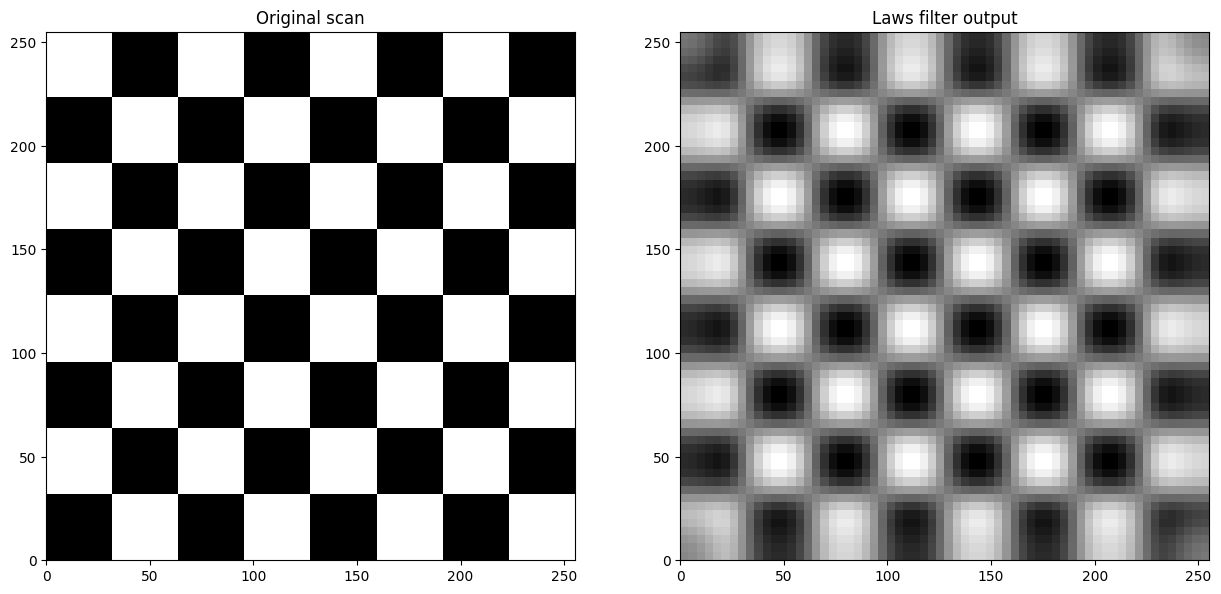

In [12]:
# Plot center slice
scanSize = np.shape(origScanArray)
centerSlc = np.round(scanSize[2]/2).astype(int)
print('Slice '+ str(centerSlc))      

window_center = 40
window_width = 400
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

windowed_img = window_image(origScanArray[:,:,centerSlc],
                                window_center,window_width)
ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
ax1.title.set_text('Original scan')

windowed_img = window_image(textureMap[:,:,centerSlc],
                                window_center,window_width)
ax2.imshow(windowed_img,cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent) 
ax2.title.set_text('Law''s filter output')


### Interactive display

In [20]:
# Interactive display

def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
        
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
    window_center = 40
    window_width = 400
    windowed_img = window_image(origScanArray[:,:,slcNum-1],
                                window_center,window_width)
    ax1.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    ax1.title.set_text('Original scan')
    
    
    windowed_img = window_image(textureMap[:,:,slcNum-1],
                                window_center,window_width)
    ax2.imshow(textureMap[:,:,slcNum-1],cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent) 
    ax2.title.set_text('Law''s filter output')
    plt.show()

slice_slider = widgets.IntSlider(value=10,min=1,max=22,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)

def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')